In [2]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
import random
from scipy.interpolate import interp1d
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
# # 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

### 导入数据

In [3]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df2 = df.copy(deep=True) 

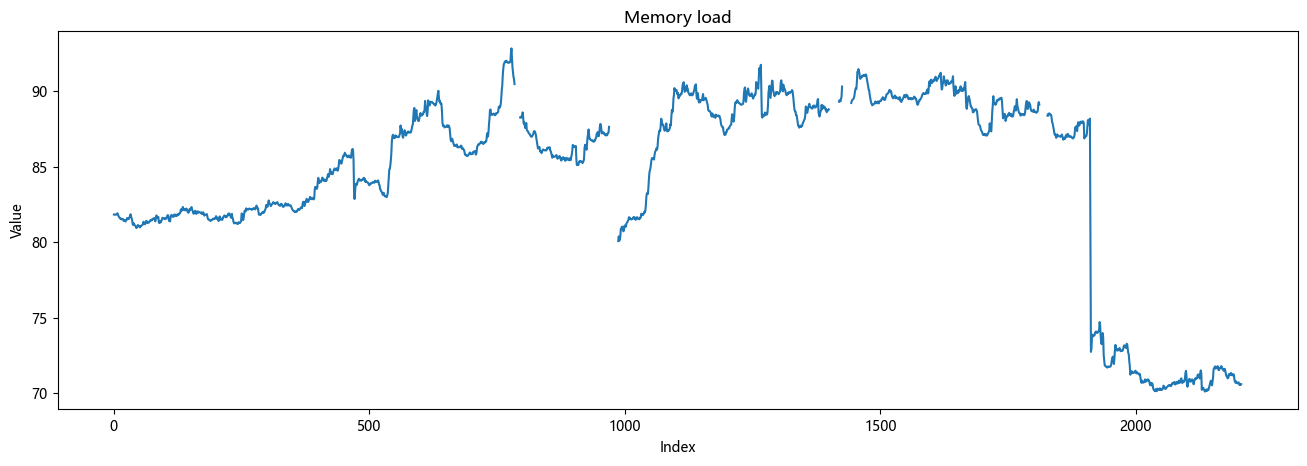

In [4]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

### 缺失值填充

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

In [6]:
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)

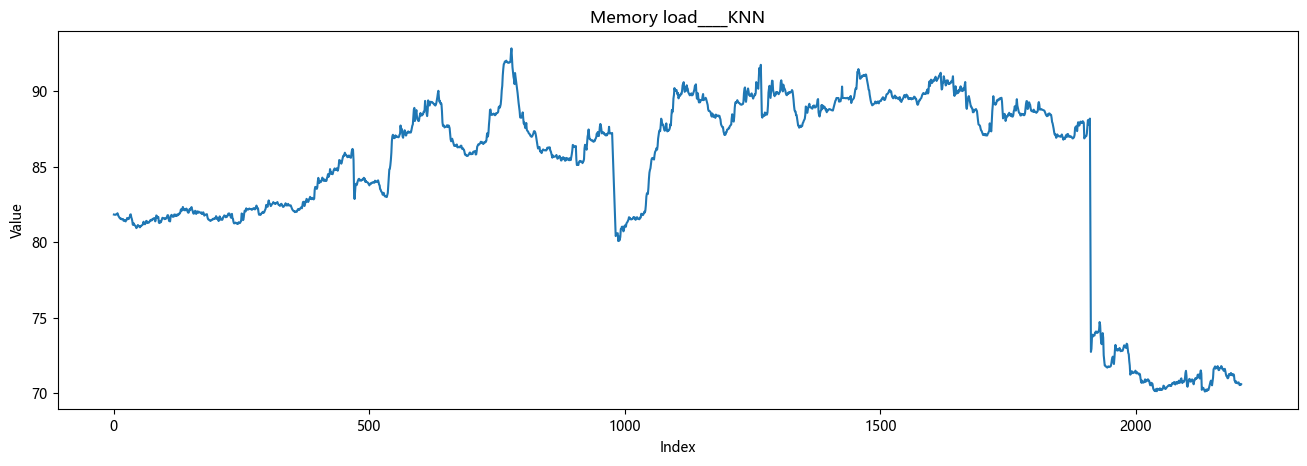

In [7]:
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load____KNN')

In [9]:
arr = df["内存负载"]
train = arr[0:2046]
test = arr[2046:]
train

0       81.8242
1       81.8145
2       81.8092
3       81.8042
4       81.8333
         ...   
2041    70.1142
2042    70.2800
2043    70.2300
2044    70.2342
2045    70.2167
Name: 内存负载, Length: 2046, dtype: float64

In [43]:
# 定阶后的单步预测
model = sm.tsa.ARIMA(train, order=(0, 1, 4))
result = model.fit()
te = result.forecast(12)[0]
te = te.tolist()

In [44]:
# # 迭代预测方法
# train_temp = train
# error = []
# truth = []
# for i in range(12):
#     if len(error) != 0:
# #         train_temp = train_temp[1:].append(pd.Series(error[i-1]))
#         train_temp = train_temp.append(pd.Series(error[i-1]))
# #         print(train_temp)
#     model = sm.tsa.ARIMA(train_temp, order=(0, 1, 4))
#     result = model.fit()
#     te = result.forecast()[0]
#     error.append(te[0])
# error

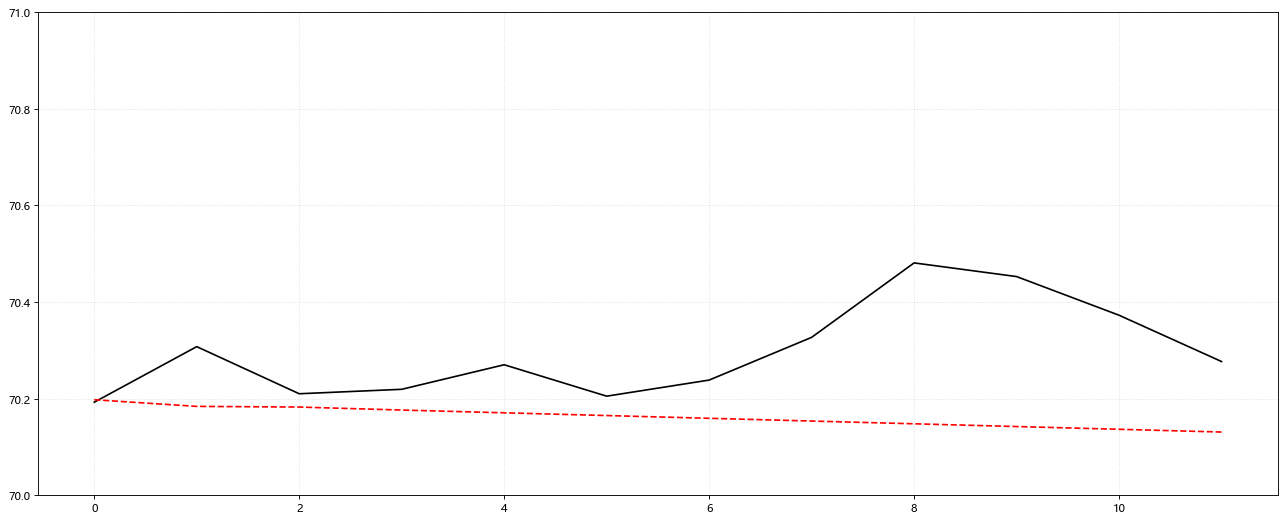

In [45]:
y_1 = df["内存负载"][2046:2058]
# 迭代策略
# 模型输入数据集长度不变
y_2 = te
# 模型过去一周训练,变长预测
# y_3 = temp2
# # 直接策略
# y_3 = [88.76133487,88.67568213,88.80482849,
#        88.82377398,89.87014746,89.68174806,90.31510764,88.94456323,89.2641398,89.53729765]
# # 神经网络
# y_4 = [88.5779,88.3317,88.394,88.3592,88.4777,88.8119,88.843,89.0937,88.8181,88.6788]
x = range(12)
 
#设置图形大小
plt.figure(figsize=(20,8),dpi=80)
# color可以百度颜色代码
plt.plot(x,y_1,label="truth",color="black")
plt.plot(x,y_2,label="pre1",color="red",linestyle="--")
# plt.plot(x,y_3,label="pre2",color="blue",linestyle="--")
plt.ylim(70,71)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')

#展示
plt.show()

In [48]:
MSE = 0
error = []
for i in range(12):
    err =  df["内存负载"].loc[2046+i] - te[i]
    error.append(err)
    MSE += (err)**2
MSE

0.3498634192725642

In [49]:
error

[-0.0051311868503631786,
 0.12361977310621342,
 0.0275387370117528,
 0.042940150495439866,
 0.09942670094049788,
 0.040113251385562876,
 0.0790998018306226,
 0.17318635227569246,
 0.33297290272075486,
 0.31035945316581603,
 0.23604600361088046,
 0.14593255405594618]

### 差分

In [10]:
# 差分法生成序列
dif = []
dif = train.diff(1)

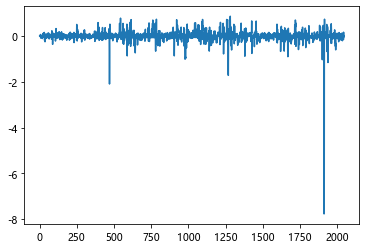

In [11]:
plt.plot(dif)

In [12]:
type(dif)

pandas.core.series.Series

### ADF检验

In [13]:
timeSeries = dif[1:]
adftest = ts.adfuller(timeSeries)
adftest

(-23.367719484989472,
 0.0,
 2,
 2042,
 {'1%': -3.433556434584693,
  '5%': -2.862956446160557,
  '10%': -2.5675240526993854},
 597.5348552992241)

### 白噪声检验

In [14]:
acorr_ljungbox(timeSeries, lags=1)

D:\Softwore\python38\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([344.34376022]), array([7.22593892e-77]))

In [15]:
# 一阶差分后p值远小于0.05,因此差分后的序列是平稳非白噪声序列

<ipython-input-16-76021bd838cb>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(timeSeries).show()


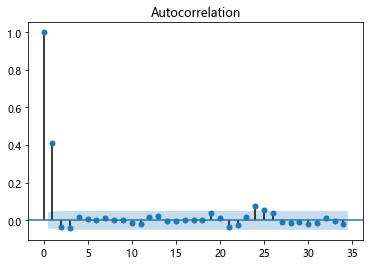

In [16]:
plot_acf(timeSeries).show()

<ipython-input-17-6211f80bbc7a>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(timeSeries).show()


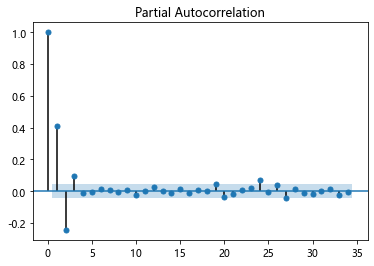

In [17]:
plot_pacf(timeSeries).show()

In [18]:
timeSeries

1      -0.0097
2      -0.0053
3      -0.0050
4       0.0291
5       0.0017
         ...  
2041   -0.1566
2042    0.1658
2043   -0.0500
2044    0.0042
2045   -0.0175
Name: 内存负载, Length: 2045, dtype: float64

### ACF定阶

In [19]:
#画图定阶

In [20]:
# ACF和PACF定阶
#利用ACF和PACF判断模型阶数
# plot_acf(arr).show() #延迟数

In [21]:
# plot_pacf(arr).show()

In [22]:
#设置遍历循环的初始条件，以热力图的形式展示，跟AIC定阶作用一样
p_min = 0
q_min = 3
p_max = 5
q_max = 6
d_min = 0
d_max = 1

In [23]:
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
results_bic

,MA3,MA4,MA5,MA6
AR0,NaN,NaN,NaN,NaN
AR1,NaN,NaN,NaN,NaN
AR2,NaN,NaN,NaN,NaN
AR3,NaN,NaN,NaN,NaN
AR4,NaN,NaN,NaN,NaN
AR5,NaN,NaN,NaN,NaN


In [24]:
import statsmodels.api as sm
import itertools
import seaborn as sns

In [25]:
# timeSeries = pd.Series(arr)
# type(timeSeries)

D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环2次
循环3次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环4次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环5次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环6次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环7次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: V

循环8次
循环9次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环10次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环11次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环12次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环13次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环14次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环15次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环16次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环17次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环18次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环19次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环20次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params)

循环21次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环22次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环23次
循环24次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsuppor

循环25次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环26次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环27次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环28次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环29次
循环30次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环31次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环32次
循环33次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环34次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环35次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环36次
循环37次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环38次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环39次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环40次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环41次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环42次


Text(0.5, 1.0, 'BIC')

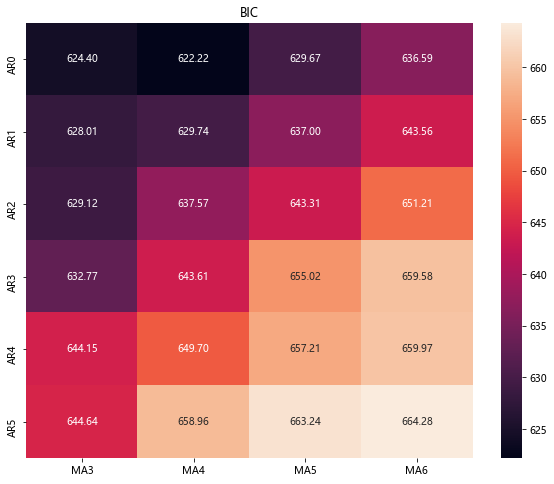

In [26]:
num = 1
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
#                                enforce_stationarity=False,
#                                enforce_invertibility=False,
                              )
        results = model.fit()
        num += 1
        print(f"循环{num}次")
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')

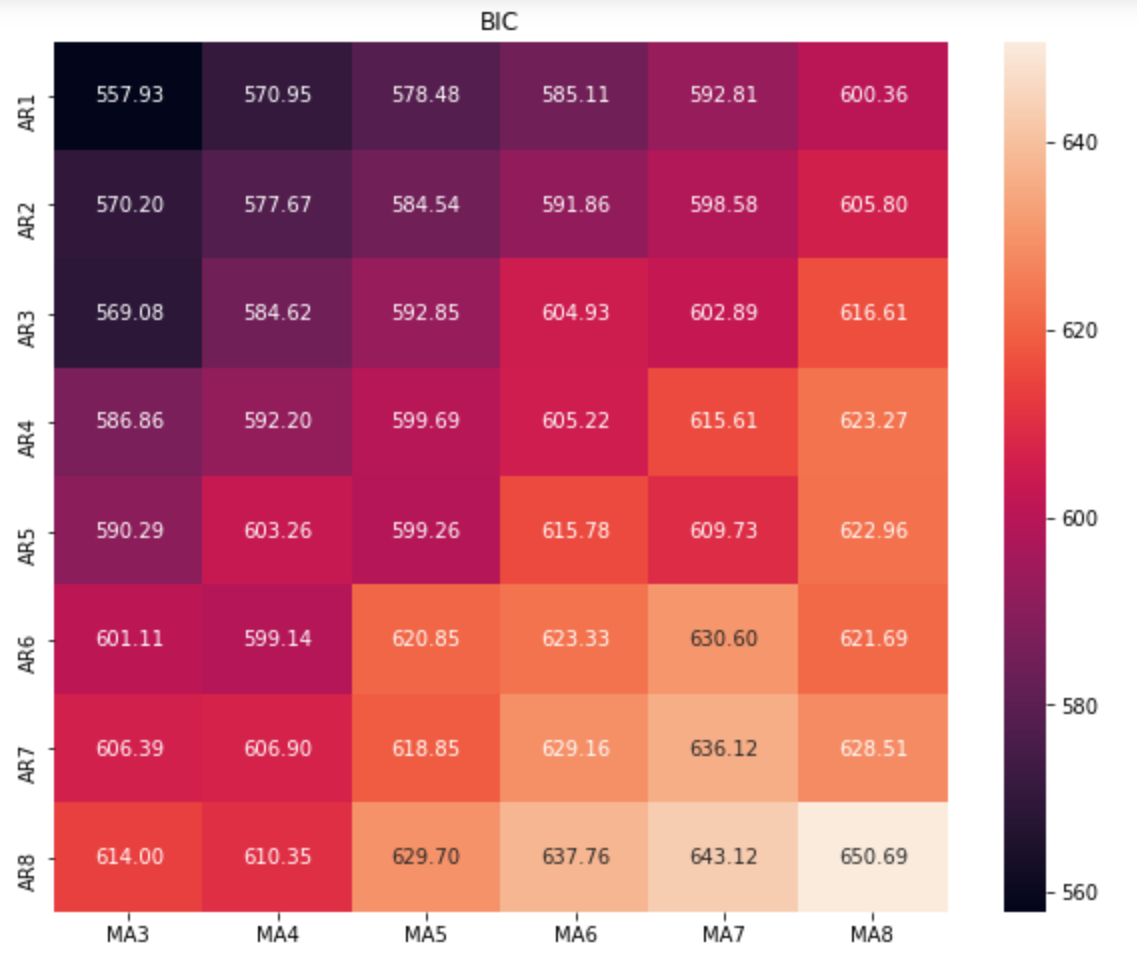

### LB残差检验

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

In [ ]:
result = lb_test(timeSeries, lags=12)
print(result[1])

In [ ]:
plt.plot(range(len(result[1])), result[1])

In [ ]:
model = sm.tsa.ARIMA(df["内存负载"], order=(1, 1, 2))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)

In [ ]:
model = sm.tsa.ARIMA(df["内存负载"], order=(1, 1, 2))
result = model.fit()

In [ ]:
result.forecast()[0]

In [ ]:
import matplotlib
print(matplotlib.get_configdir())